In [52]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [53]:
data_dir='data/Garbage classification'
# data_dir='image'
classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## 轉換:

In [54]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)
test_ds = ImageFolder('image', transform = transformations)


In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)


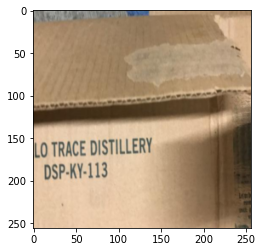

In [56]:
img, label = dataset[12]
show_sample(img, label)

# Load and Split:

In [57]:
random_seed = 42
torch.manual_seed(random_seed)

In [58]:
train_ds, val_ds = random_split(dataset, [2349, 176])
len(train_ds), len(val_ds), len(test_ds)

(2349, 176, 87)

In [59]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [60]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

In [61]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

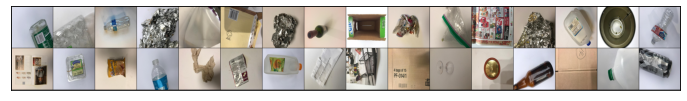

In [62]:
show_batch(train_dl)

# Model Base:

In [63]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

用 ResNet50 來 classifying images:

In [64]:
import os

class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # 使用 pretrained 的 model
        self.network = models.resnet50(pretrained=True)
        # 取代最後一層
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

if os.path.exists('./new_model') :
    model.load_state_dict(torch.load('./new_model'))

## Porting to GPU:

In [65]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

In [66]:
device = get_default_device()
device

device(type='cuda')

In [67]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

# Training the Model:

In [68]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [69]:
model = to_device(ResNet(), device)

In [70]:
evaluate(model, val_dl)

{'val_loss': 1.7863825559616089, 'val_acc': 0.1493055671453476}

training the model:

In [71]:
num_epochs = 12
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.3957, val_loss: 1.1944, val_acc: 0.8872
Epoch 2: train_loss: 1.1348, val_loss: 1.1505, val_acc: 0.9045
Epoch 3: train_loss: 1.0822, val_loss: 1.1336, val_acc: 0.9253
Epoch 4: train_loss: 1.0690, val_loss: 1.1052, val_acc: 0.9340
Epoch 5: train_loss: 1.0617, val_loss: 1.1247, val_acc: 0.9271
Epoch 6: train_loss: 1.0574, val_loss: 1.1182, val_acc: 0.9288
Epoch 7: train_loss: 1.0552, val_loss: 1.1105, val_acc: 0.9410
Epoch 8: train_loss: 1.0565, val_loss: 1.1076, val_acc: 0.9444
Epoch 9: train_loss: 1.0584, val_loss: 1.1093, val_acc: 0.9323
Epoch 10: train_loss: 1.0544, val_loss: 1.1362, val_acc: 0.9010
Epoch 11: train_loss: 1.0567, val_loss: 1.1085, val_acc: 0.9410
Epoch 12: train_loss: 1.0525, val_loss: 1.1063, val_acc: 0.9410


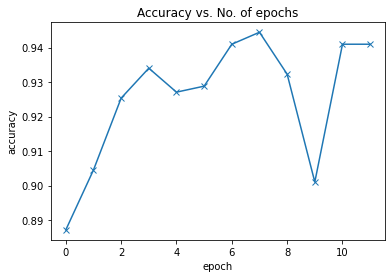

In [72]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

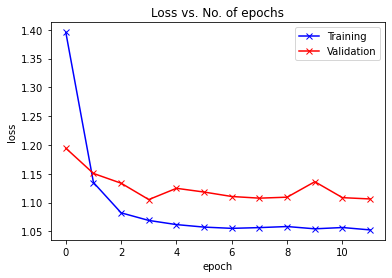

In [73]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

 Visualizing Predictions:

In [79]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)  # Convert to a batch of 1
    yb = model(xb)                            # Get predictions from model
    prob, preds  = torch.max(yb, dim=1)       # Pick index with highest probability
    return dataset.classes[preds[0].item()]   # Retrieve the class label

Label: glass , Predicted: glass


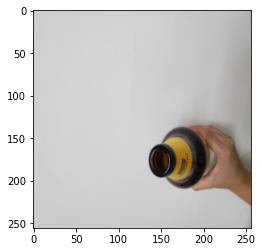

In [75]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: glass , Predicted: glass


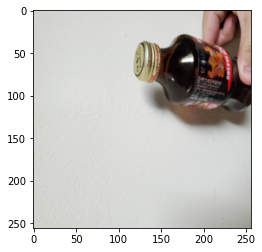

In [76]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [77]:
# img, label = test_ds[5]
# plt.imshow(img.permute(1, 2, 0))
# print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))
hit = 0
total = 0
for i in range(len(test_ds)):
    img, label = test_ds[i]
    print("label:", dataset.classes[label], " ,predict:", predict_image(img, model))
    if dataset.classes[label] == predict_image(img, model):
        hit += 1
    total += 1
print("hit:", hit)
print("total:", total)
print("accuracy:", hit/total)

label: cardboard  ,predict: cardboard
label: cardboard  ,predict: cardboard
label: cardboard  ,predict: cardboard
label: cardboard  ,predict: cardboard
label: cardboard  ,predict: paper
label: cardboard  ,predict: cardboard
label: cardboard  ,predict: cardboard
label: cardboard  ,predict: cardboard
label: cardboard  ,predict: cardboard
label: cardboard  ,predict: cardboard
label: cardboard  ,predict: cardboard
label: cardboard  ,predict: cardboard
label: cardboard  ,predict: cardboard
label: cardboard  ,predict: cardboard
label: glass  ,predict: glass
label: glass  ,predict: glass
label: glass  ,predict: glass
label: glass  ,predict: glass
label: glass  ,predict: glass
label: glass  ,predict: glass
label: glass  ,predict: glass
label: glass  ,predict: glass
label: glass  ,predict: glass
label: glass  ,predict: glass
label: glass  ,predict: glass
label: glass  ,predict: glass
label: glass  ,predict: glass
label: glass  ,predict: glass
label: glass  ,predict: glass
label: glass  ,predict

load the model

In [ ]:
loaded_model = model
# torch.save(loaded_model.state_dict(), './saved_model')
loaded_model.load_state_dict(torch.load('./new_model'))

<All keys matched successfully>